<h1 style="text-align: center;">Desafío - Clasificación desde el Machine Learning</h1>

- Para realizar este desafío debes haber estudiado previamente todo el material disponible correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío: Individual.
Para la realización del desafío necesitarás apoyarte del archivo <a href="https://empieza.desafiolatam.com/cohorts/2091/sections/78289/activities/119118/items/610931">Apoyo Desafío - Clasificación desde el aprendizaje de máquinas</a>.

## Descripción
En esta sesión trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
- `default`: Variable binaria. Registra si el cliente entró en morosidad o no. **(Vector objetivo)**
- `income`: Ingreso promedio declarado por el cliente.
- `balance`: Total de saldo en la cuenta de crédito.
- `student`: Variable binaria. Registra si el cliente es estudiante o no

### Desafío 1: Preparación del ambiente de trabajo
- Importe los módulos básicos para el análisis de datos
- Importe `seaborn`.
- Importe `statsmodels`.
- Importe `LogisticRegression`, `train_test_split`, `StandardScaler`, `classification_report` y `roc_curve` de `sklearn`.

In [1]:
# Utiliza esta celda para importar los módulos solicitados y el set de datos
#manejo de datos
import pandas as pd
import numpy as np

#Graficas
import seaborn as sns
import matplotlib.pyplot as plt

#Econometria
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#metricas
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

#otras
import warnings
warnings.simplefilter("ignore")

df = pd.read_csv("default_credit.csv").drop("index", axis = 1)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [2]:
df.value_counts("default")

default
No     9667
Yes     333
dtype: int64

**Comentarios**: Aca se observa que existe un desbalance en el vector objetivo

### Desafío 2: Análisis exploratorio
Explore las principales relaciones entre las variables. Utilizando los métodos `boxplot` y `lmplot` de `seaborn` implemente los siguientes gráficos. _**tip**_: Puede utilizar el parámetro `hue` en `lmplot` para identificar las observaciones por status.

- Un `boxplot` del balance total de las cuentas, segmentado por el status de estudiante.

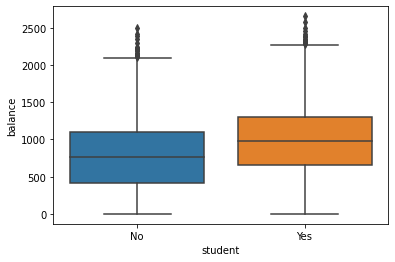

In [3]:
# Utiliza esta celda para realizar el gráfico solicitado 
sns.boxplot(x = df["student"], y = df["balance"]);

**Comentarios**: El balance es mas alto en los estudiantes, tienen un mayor saldo en sus cuentas, aunque con unas medianas cercanas

- Un `boxplot` del ingreso total de cada cliente, segmentado por el status de estudiante.

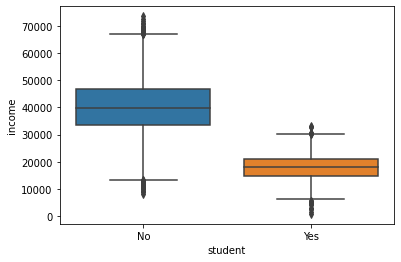

In [4]:
# Utiliza esta celda para realizar el gráfico solicitado
sns.boxplot(x = df["student"], y = df["income"]);

**Comentarios**: Los estudiantes tienen un ingreso menor, y tambien una dispersion menor, con medianas notoriamente diferentes

- Un `boxplot` del balance total de las cuentas, segmentado por el status de default.

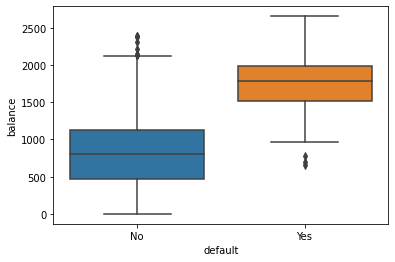

In [5]:
# Utiliza esta celda para realizar el gráfico solicitado
sns.boxplot(x = df["default"], y = df["balance"]);

**Comentarios**: los estudiantes tienen una morosidad mas alta, con medianas muy diferentes

- Un `boxplot` del ingreso total de cada cliente, segmentado por el status de default.

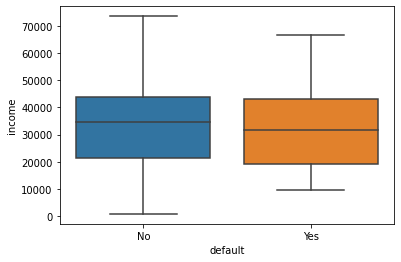

In [6]:
# Utiliza esta celda para realizar el gráfico solicitado 
sns.boxplot(x = df["default"], y = df["income"]);

**Comentarios**: Con respecto a la variable default, los que no tienen deuda tienen un ingreso mas alto, segun sus medianas, pero con una dispersion mayor 

- Un diagrama de dispersión entre balance e income, segmentado por el status de estudiante.

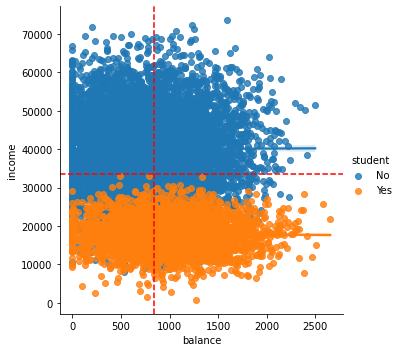

In [7]:
# Utiliza esta celda para realizar el gráfico solicitado
sns.lmplot(data = df, x="balance", y = "income", hue="student")
plt.axvline(df["balance"].mean(), color = "red", ls="--")
plt.axhline(df["income"].mean(), color = "red", ls="--")

**Comentarios**: Se aprecia una polarizacion marcada del ingreso de los estudiantes y no estudiantes, tambien existe personas que no son estudiantes que estan bajo la media. En cuanto balance, se puede apreciar lo que se veia en el boxplot, que tenian un mayor balance los estudiantes

- Un diagrama de dispersión entre balance e income, segmentado por el status de default.

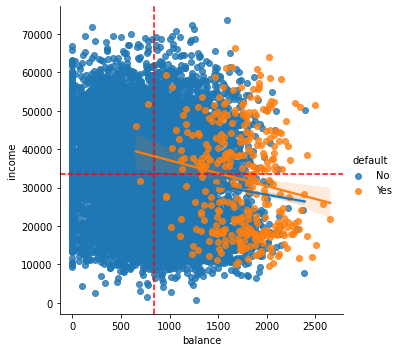

In [8]:
# Utiliza esta celda para realizar el gráfico solicitado
sns.lmplot(data = df, x="balance", y = "income", hue="default")
plt.axvline(df["balance"].mean(), color = "red", ls="--")
plt.axhline(df["income"].mean(), color = "red", ls="--")

**Comentarios**: Se pueden ver que hay una mayor cantidad de personas sin deudas deudas, y tambien que la mayoria de los con deudas se encuentran sobre la media de balance, en cuanto al ingreso tienen un distribucion parecida.

### Desafío 3: Modelación econométrica
- Recodifique las variables `student` y `default` para que adquieran atributos numéricos.

In [9]:
# Utiliza esta celda para realizar las codificaciones solicitadas. Puedes usar LabelEncoder.
df["default_bin"] = np.where(df["default"] == "Yes", 1, 0)
df["student_bin"] = np.where(df["student"] == "Yes", 1, 0)

In [10]:
df

,default,student,balance,income,default_bin,student_bin
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0
...,...,...,...,...,...,...
9995,No,No,711.555020,52992.378914,0,0
9996,No,No,757.962918,19660.721768,0,0
9997,No,No,845.411989,58636.156984,0,0
9998,No,No,1569.009053,36669.112365,0,0


- Implemente el siguiente modelo econométrico:
$$
\log\left(\frac{p(\text{default}=1)}{1-p(\text{default}=1)}\right)_i = \beta_0 + \beta_{balance} \cdot \text{balance}_i + \beta_{income} \cdot \text{income}_i + \beta_{student} \cdot \text{student}_i
$$

In [11]:
# Utiliza esta celda para entrenar el modelo solicitado
modelo = smf.logit("default_bin ~ balance + income + student_bin", df).fit()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


In [12]:
modelo.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.462      
Dependent Variable: default_bin      AIC:              1579.5448  
Date:               2022-09-04 19:50 BIC:              1608.3862  
No. Observations:   10000            Log-Likelihood:   -785.77    
Df Model:           3                LL-Null:          -1460.3    
Df Residuals:       9996             LLR p-value:      3.2575e-292
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       -10.8690   0.4923 -22.0793 0.0000 -11.8339 -9.9042
balance           0.0057   0.0002  24.7365 0.0000   0.0053  0.0062
income            0.0000   0.0000   0.3698 0.7115  -0.0000  0.0000
student_bin      -0.6468   0.2363  -2.7376 0.0062  -1.1098 -0.1837
==================================================================

"""

- A partir de este modelo, depúrelo y mantenga las principales características. Ejecute de nuevo el modelo y comente brevemente sobre el comportamiento de los atributos.

In [13]:
# Utiliza esta celda para mostrar los coeficientes sifnificativos al 95% de confianza
coefs = modelo.summary2().tables[1]

coefs[coefs["P>|z|"] < 0.05]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
student_bin,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


In [14]:
# Utiliza esta celda para entrenar el modelo depurado
modelo_depurado = smf.logit("default_bin ~ balance + student_bin", df).fit()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


In [15]:
# Utiliza esta celda para mostrar los coeficientes significativos que influyen positivamente en el modelo depurado
coefs_dep = modelo_depurado.summary2().tables[1]

coefs_dep[coefs_dep["Coef."] > 0] 

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
balance,0.005738,0.000232,24.74847,3.220126e-135,0.005284,0.006193


In [16]:
# Utiliza esta celda para mostrar los coeficientes significativos que influyen negativamente en el modelo depurado
coefs_dep[coefs_dep["Coef."] < 0] 

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.749496,0.369209,-29.114925,2.323735e-186,-11.473132,-10.025859
student_bin,-0.714878,0.147522,-4.845910,1.260326e-06,-1.004015,-0.425740


In [17]:
modelo_depurado.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.462      
Dependent Variable: default_bin      AIC:              1577.6816  
Date:               2022-09-04 19:50 BIC:              1599.3126  
No. Observations:   10000            Log-Likelihood:   -785.84    
Df Model:           2                LL-Null:          -1460.3    
Df Residuals:       9997             LLR p-value:      1.1893e-293
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
------------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------
Intercept      -10.7495   0.3692 -29.1149 0.0000 -11.4731 -10.0259
balance          0.0057   0.0002  24.7485 0.0000   0.0053   0.0062
student_bin     -0.7149   0.1475  -4.8459 0.0000  -1.0040  -0.4257
==================================================================

"""

**Comentarios**: el modelo depurado tiene un R2 igual al sin depurar, lo cual es bueno ya que se tiene una variable que considerar. Tenemos que la variable balance influye de manera positiva y la variable student_bin de manera negativa

### Desafío 4: Entrenar
A partir del modelo depurado, genere un modelo _predictivo_ con las siguientes características:

- Genera subconjuntos de entrenamiento y pruebas, separando el 33% de la muestra en el conjunto de pruebas

In [18]:
# Utiliza esta celda para generar los subconjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(df[["balance", "student_bin"]], df["default_bin"], test_size = .33, random_state = 11238)


- Estandarice las matrices de atributos de entrenamiento y pruebas usando `StandardScaler()` ajustado solo sobre el conjunto de entrenamiento.

In [19]:
# Utiliza esta celda para estandarizar la matriz de atributos de entrenamiento y aplicar dicha estandarización tanto en train como test
scaler = StandardScaler().fit(X_train)

In [20]:
X_train_scaled = scaler.transform(X_train)

In [21]:
X_test_scaled = scaler.transform(X_test)

- Implemente el modelo sin alterar los hiper parámetros.

In [22]:
# Utiliza esta celda para generar el modelo predictivo de LogisticRegression utilizando los datos de entrenamiento
modelo_lg = LogisticRegression()

In [23]:
modelo_lg.fit(X_train_scaled, y_train)

LogisticRegression()

- Genere la predicción de las clases y de la probabilidad.

In [24]:
# Utiliza esta celda para generar y almacenar predicciones de clase y de probabilidad
y_hat = modelo_lg.predict(X_test_scaled)

In [25]:
y_hat_proba = modelo_lg.predict_proba(X_test_scaled)[:,1]

- Reporte las métricas de precisión, recall y f1 para ambas clases.

In [26]:
# Utiliza esta celda para reportar las métricas solicitadas utilizando classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3186
           1       0.73      0.32      0.45       114

    accuracy                           0.97      3300
   macro avg       0.85      0.66      0.72      3300
weighted avg       0.97      0.97      0.97      3300



- Grafique la curva Receiver Operator Characteristic.

In [27]:
# Utiliza esta celda para graficar la curva ROC
false_positive, true_positive, threshold = roc_curve(y_test, y_hat_proba)

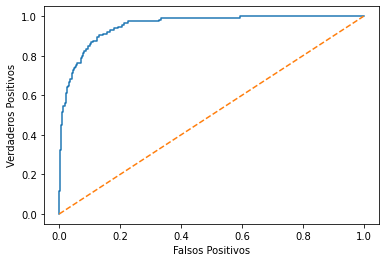

In [28]:
plt.plot(false_positive, true_positive)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos")
plt.plot([0,1], linestyle = "--")

In [29]:
roc_auc_score(y_test, y_hat_proba)

0.9531971013535093

- En base a los pasos, comente sobre el desempeño predictivo del modelo haciendo mención a todas las métricas calculadas y a la curva ROC.

**Comentarios**: el modelo es bueno reconociendo los casos "0", pero no los "1", esto se puede ver con la precision, el recall y el f1-score. Esto se puede ver que hay muchos casos de caso 0 como se ve en el support(esta desbalanceada), por eso en algunas ocasiones no es "tan" confiable el accuracy. . Tambien tiene un 0.95 en la curva ROC, es decir, un 95% de probabilidad de acertar correctamente, pero resaltando lo anterior, es buen modelo para reconocer 0.
Aunque todo esto, depende del objetivo del modelo, que es lo que se requiere reconocer, para saber si el modelo es realmente bueno o malo.
